In [1]:
%pylab inline
import pandas as pd
#from sklearn.datasets import load_digits

Populating the interactive namespace from numpy and matplotlib


In [2]:
#digits = load_digits()
#imshow(digits.images[7])

In [87]:
pat_num=600
iTrain=500
d = loadtxt("mnist_train.csv", delimiter=",",max_rows=pat_num)
dClasses=[int(c) for c in d[:iTrain,0]]
tClasses=[int(c) for c in d[iTrain:,0]]
data=d[:iTrain,:]
test=d[iTrain:,:]

In [88]:
poka = lambda x : imshow(x, cmap=cm.gist_gray_r)

### average_digits
funkcja tworzy wzorce do uczenia uśredniając obrazki danych liczb. Zamienia też wartości liczbowe neuronów z 0-255 na -1 lub 1
#### input:
    data - dane posiadające informacje o poszczególnych wartościach liczbowych neuronów - numpy array shape(N,785)
    classes - klasy odpowiadające jaka liczba jest zakodowana w data
    number - liczba, którą chcemy uśrednić - int
    threshold - od jakiej liczby neuron ma mieć wartość 1 - double (0.0:1.0)
    N_train - liczba pierwszych wzorów przeznaczonych do uczenia (po których będzie uśrednianie) - int
#### output:
    avg - wzór z wartościami 1 lub -1 - numpy array shape(784,)

In [89]:
def average_digits(data, number, threshold=0.5):
    avg = data[data[:,0]==number][:,1:].mean(axis=0)
    avg=recalculate_digit(avg,threshold)
    return avg

### recalculate_digit
funkcja ma na celu przerzucenie wartości nauronów z liczb 0-255 na -1 lub 1
#### input:
    data - wzorzec do zmiany - numpy array shape(784,)
    threshold - od jakiej liczby neuron ma mieć wartość 1 - double (0.0,1.0)
#### output
    pat - wzorzec z 1 lub -1 - numpy array shape(784,)
    
    

In [90]:
def recalculate_digit(data, threshold=0.5):
    pat= data/255
    for i in range(len(pat)):
        if pat[i]>threshold:
            pat[i]=1
        else:
            pat[i]=0
        
    pat=pat*2-1
    return pat

### calculate_cover:
funkcja zwraca wartość liczbową przekrycia wyniku predykcji z danym wzorem. Pozwala to na późniejsze wybranie jaka liczba została rozpoznana
#### input:
    X - wynik predykcji. Wartości neuronów {-1,1} - numpy array shape(784,)
    pat - wzorzec, do którego porównujemy. Wartości neuronów {-1,1} - numpy array shape(784,)
#### output:
    score - procentowe porównanie pokrycia wzorca przez wynik predykcji - numpy array::double (0.0,1.0)-> shape(10,)

In [91]:
def calculate_cover(X,pat):
    score=zeros(10)
    i=0
    for p in pat:
        #score[i]=numpy.count_nonzero((X==p))/784
        score[i]=X@p/pat.shape[1]
        i+=1
    return score

### predict
funkcja do predykcji liczby z pisma ręcznego.
#### input:
    X - dane posiadające informacje o poszczególnych wartościach liczbowych neuronów - numpy array shape(784,)
    pat - wzorce, na których została nauczona sieć - numpy array shape(10,784)
    W - macierz wag nauczonej sieci - numpy array shape(784,784)
#### output:
    val - predykcja liczby - int
    X - końcowe wartości liczbowe poszczególnych neuronów - numpy array shape(784,)

In [92]:
def predict(X,pat, W):
    N=pat.shape[1]
    Xn=zeros(N)
    is_stable=0 # przez ile fitowań nie zmienia się predykcja
    last_predict=-1 # jaka była ostatnia predykcja

    while is_stable<2:
        M=zeros(pat.shape[0])
        for i in range(N):
            for j in range(N):
                Xn[i]+=W[i,j]*X[j]
        X=sign(Xn)
        M=calculate_cover(X,pat)
        if argmax(abs(M))==last_predict:
            is_stable+=1
        last_predict=argmax(abs(M))
    
    val=argmax(abs(M))
    return val,X

przygotowanie wzorców do nauczenia modelu

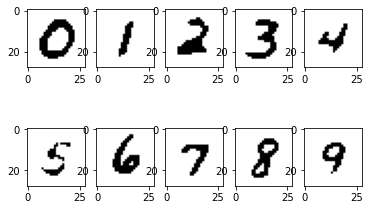

In [105]:
N=784
pat = zeros((10,784))
for i in range(10):
    pat[i] = average_digits(data,i,0.45)

i=1
for p in pat:
    subplot(2,5,i)
    i+=1
    poka(p.reshape(28,28))

In [106]:
pat.shape

(10, 784)

In [107]:
#poka(d[d[:,0]==5][:,1:].mean(axis=0).reshape(28,28))

In [161]:
W=pat.T @ pat / pat.shape[0]
W-=eye(N,N)

Testowanie poszczególnych liczb

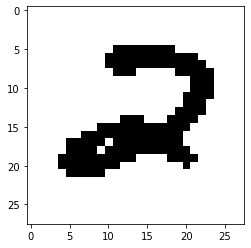

In [162]:
pat_test = test[:,1:][15]
X=recalculate_digit(pat_test,0.45)
poka(reshape(X,(28,28)))

[0.61479592 0.81122449 0.83928571 0.74744898 0.83928571 0.81887755
 0.75765306 0.83418367 0.83163265 0.86989796]
9


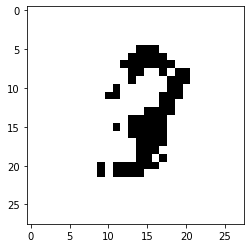

In [163]:
Xn=zeros(N)
is_stable=0 # przez ile fitowań nie zmienia się predykcja
last_predict=-1 # jaka była ostatnia predykcja

M=zeros(pat.shape[0])
for i in range(N):
    for j in range(N):
        Xn[i]+=W[i,j]*X[j]
X=sign(Xn)
poka(reshape(X,(28,28)));
M=calculate_cover(X,pat)
#     if argmax(abs(M))==last_predict:
#         is_stable+=1
#     last_predict=argmax(abs(M))
        
poka(reshape(X,(28,28)));
print(M)
print(argmax(abs(M)))

testowanie skuteczności (macierz pomyłek)

In [164]:
macierz = zeros((10,10))
output = zeros(10)
n=0 # liczba testów
for t in range(test.shape[0]):
    pat_test = test[:,1:][t]
    X_t=recalculate_digit(pat_test,0.25)
    val,X = predict(X_t,pat,W)
    output[val]+=1
    macierz[tClasses[t],val]+=1
    n+=1

In [165]:
output

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.])

In [166]:
for i in range(10):
    macierz[:,i]/=output[i]

<ipython-input-166-bbbc97089081>:2: RuntimeWarning: invalid value encountered in true_divide
  macierz[:,i]/=output[i]


Macierz pokazuje jak zostały zidentyfikowane poszczególne przykłady. Kolumny oznaczają predykcję liczby, a wiersze poprawną wartość liczby z przykładu.

In [167]:
c=["0","1","2","3","4","5","6","7","8","9"] 
df=pd.DataFrame(data=macierz,index=c,columns=c)
df.rename_axis('True', axis = 'rows')
df.rename_axis('Predict', axis = 'columns')
df

,0,1,2,3,4,5,6,7,8,9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10
